In [3]:
import os, json, math, random, pathlib
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [4]:
# ================== 1. CONFIG ==================
SEED = 42
random.seed(SEED)
tf.random.set_seed(SEED)

DATA_EXPECTED_SUBDIR = "Split_smol"
TRAIN_SUB = "train"
VAL_SUB   = "val"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

PHASE1_EPOCHS = 6
PHASE2_EPOCHS = 24
PHASE1_LR = 2e-4
PHASE2_LR = 1e-5

DROPOUT_RATE = 0.6
L2_REG = 1e-4
LABEL_SMOOTH = 0.05         # Slight smoothing (since Mixup also regularizes)
MIXUP_ALPHA = 0.3           # Set 0 to disable mixup easily
USE_MIXUP = True            # Toggle Mixup on/off
USE_PREPROCESS_INPUT = True # If False, will use rescale=1./255 instead
VERBOSE_PCT_LOG = True

# Open-set threshold params
PERCENTILE_Q = 5
MARGIN = 0.02

OUTPUT_DIR = "/kaggle/working"
os.makedirs(OUTPUT_DIR, exist_ok=True)
BEST_CKPT_PATH   = os.path.join(OUTPUT_DIR, "densenet_openset_best.h5")
FINAL_MODEL_PATH = os.path.join(OUTPUT_DIR, "DenseNet_OpenSet.h5")
CONFIG_PATH      = os.path.join(OUTPUT_DIR, "inference_config.json")

In [5]:
# ================== 2. DATASET DISCOVERY ==================
def discover_split_base(expected=DATA_EXPECTED_SUBDIR):
    """
    Locate a directory named 'expected' that contains 'train' and 'val' inside /kaggle/input.
    Handles nested duplication.
    """
    root = pathlib.Path("/kaggle/input")
    if not root.exists():
        raise FileNotFoundError("/kaggle/input does not exist - are you on Kaggle?")
    candidates = []
    for top in root.iterdir():
        if not top.is_dir():
            continue
        direct = top / expected
        if (direct / TRAIN_SUB).is_dir() and (direct / VAL_SUB).is_dir():
            candidates.append(direct)
        nested = top / top.name / expected
        if (nested / TRAIN_SUB).is_dir() and (nested / VAL_SUB).is_dir():
            candidates.append(nested)
        if top.name == expected and (top / TRAIN_SUB).is_dir() and (top / VAL_SUB).is_dir():
            candidates.append(top)
    if not candidates:
        raise FileNotFoundError(
            f"Could not locate {expected}/train and {expected}/val in any /kaggle/input/* directory. "
            "Attach the dataset via 'Add Data'."
        )
    candidates.sort(key=lambda p: len(str(p)))
    base = candidates[0]
    print(f"[Data] Using base directory: {base}")
    return str(base)

try:
    BASE_DIR = discover_split_base()
except FileNotFoundError as e:
    # If discovery fails, hard-code here as fallback (uncomment & adjust):
    # BASE_DIR = "/kaggle/input/skin-disease-classification-image-dataset/Split_smol"
    raise

TRAIN_DIR = os.path.join(BASE_DIR, TRAIN_SUB)
VAL_DIR   = os.path.join(BASE_DIR, VAL_SUB)

assert os.path.isdir(TRAIN_DIR), f"Train dir missing: {TRAIN_DIR}"
assert os.path.isdir(VAL_DIR),   f"Val dir missing: {VAL_DIR}"

[Data] Using base directory: /kaggle/input/skin-disease-classification-image-dataset/Split_smol


In [6]:
# ================== 3. IMAGE DATA GENERATORS ==================

if USE_PREPROCESS_INPUT:
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
else:
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_gen.class_indices.keys())
num_classes = len(class_names)
print(f"[Data] Classes ({num_classes}): {class_names}")

Found 697 images belonging to 9 classes.
Found 181 images belonging to 9 classes.
[Data] Classes (9): ['Actinic keratosis', 'Atopic Dermatitis', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Tinea Ringworm Candidiasis', 'Vascular lesion']


In [7]:
# ================== 4. MIXUP GENERATOR (OPTIONAL) ==================
def sample_beta(alpha):
    g1 = tf.random.gamma([], alpha, 1.0)
    g2 = tf.random.gamma([], alpha, 1.0)
    return g1 / (g1 + g2)

def mixup_wrapper(generator, alpha):
    """
    Wrap a Keras DirectoryIterator to yield mixup batches.
    """
    while True:
        x_batch, y_batch = next(generator)  # numpy arrays
        if alpha <= 0:
            yield x_batch, y_batch
            continue
        lam = sample_beta(alpha)
        lam = tf.cast(lam, tf.float32)
        x = tf.convert_to_tensor(x_batch, dtype=tf.float32)
        y = tf.convert_to_tensor(y_batch, dtype=tf.float32)
        perm = tf.random.shuffle(tf.range(tf.shape(x)[0]))
        x2 = tf.gather(x, perm)
        y2 = tf.gather(y, perm)
        x_mix = lam * x + (1.0 - lam) * x2
        y_mix = lam * y + (1.0 - lam) * y2
        yield x_mix, y_mix

if USE_MIXUP and MIXUP_ALPHA > 0:
    train_iter = mixup_wrapper(train_gen, MIXUP_ALPHA)
    steps_per_epoch = len(train_gen)
    print(f"[Mixup] Enabled (alpha={MIXUP_ALPHA})")
else:
    train_iter = train_gen
    steps_per_epoch = len(train_gen)
    print("[Mixup] Disabled")

[Mixup] Enabled (alpha=0.3)


In [8]:
# ================== 5. MODEL ==================
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(DROPOUT_RATE)(x)
outputs = Dense(num_classes,
                activation='softmax',
                kernel_regularizer=regularizers.l2(L2_REG))(x)
model = Model(inputs=base_model.input, outputs=outputs)

loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTH)
metrics = ['accuracy']

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, min_lr=1e-6)
checkpoint = ModelCheckpoint(BEST_CKPT_PATH, monitor='val_loss', save_best_only=True)

I0000 00:00:1757238827.758855      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757238827.759645      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
# ================== 6. TRAIN PHASE 1 (HEAD) ==================
base_model.trainable = False
model.compile(optimizer=tf.keras.optimizers.Adam(PHASE1_LR), loss=loss_fn, metrics=metrics)
print("\n[Phase 1] Training head...")
model.fit(
    train_iter,
    steps_per_epoch=steps_per_epoch,
    epochs=PHASE1_EPOCHS,
    validation_data=val_gen,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

# ================== 7. TRAIN PHASE 2 (FULL) ==================
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(PHASE2_LR), loss=loss_fn, metrics=metrics)
print("\n[Phase 2] Fine-tuning full network...")
model.fit(
    train_iter,
    steps_per_epoch=steps_per_epoch,
    epochs=PHASE2_EPOCHS,
    validation_data=val_gen,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)


[Phase 1] Training head...
Epoch 1/6


I0000 00:00:1757238875.846908     119 service.cc:148] XLA service 0x7b23dc020f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757238875.848526     119 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757238875.848557     119 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757238878.518596     119 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/22 ━━━━━━━━━━━━━━━━━━━━ 11:17 32s/step - accuracy: 0.0625 - loss: 3.4945

I0000 00:00:1757238890.113579     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1254 - loss: 3.2641   

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.1254 - loss: 3.2631 - val_accuracy: 0.1050 - val_loss: 2.5513 - learning_rate: 2.0000e-04
Epoch 2/6
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 591ms/step - accuracy: 0.1265 - loss: 3.1787 - val_accuracy: 0.1381 - val_loss: 2.4560 - learning_rate: 2.0000e-04
Epoch 3/6
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 555ms/step - accuracy: 0.1346 - loss: 3.0948 - val_accuracy: 0.1492 - val_loss: 2.3551 - learning_rate: 2.0000e-04
Epoch 4/6
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 567ms/step - accuracy: 0.1783 - loss: 2.8823 - val_accuracy: 0.1492 - val_loss: 2.2531 - learning_rate: 2.0000e-04
Epoch 5/6
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 555ms/step - accuracy: 0.1462 - loss: 2.8859 - val_accuracy: 0.2099 - val_loss: 2.1934 - learning_rate: 2.0000e-04
Epoch 6/6
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 549ms/step - accuracy: 0.2027 - loss: 2.8035 - val_accuracy: 0.2320 - val_loss: 2.1091 - learning_rate: 2.0000e-04

[Phase 2] Fine-tuning full network...
Epoch 1/24
22/22 ━━━━━━━━━━━━━━━━━━━━ 

In [10]:
# ================== 8. LOAD BEST ==================
if os.path.exists(BEST_CKPT_PATH):
    model = tf.keras.models.load_model(BEST_CKPT_PATH, compile=False)
    model.compile(optimizer=tf.keras.optimizers.Adam(PHASE2_LR), loss=loss_fn, metrics=metrics)
    print("[Load] Best checkpoint loaded.")

[Load] Best checkpoint loaded.


In [11]:
# ================== 9. EVALUATE ==================
val_loss, val_acc = model.evaluate(val_gen, verbose=1)
print(f"\nValidation Accuracy: {val_acc*100:.2f}%  (val_loss={val_loss:.4f})")

6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7057 - loss: 1.0010 

Validation Accuracy: 72.38%  (val_loss=0.9583)


In [12]:
# ================== 10. OPEN-SET THRESHOLD ==================
print("\n[Open-Set] Computing decision threshold...")
val_preds = model.predict(val_gen, verbose=1)
val_true_idx = val_gen.classes  # int labels in same order as batches yielded (shuffle=False)

pred_idx = val_preds.argmax(axis=1)
max_probs = val_preds.max(axis=1)

correct_mask = (pred_idx == val_true_idx)
correct_max_probs = max_probs[correct_mask]

if len(correct_max_probs) == 0:
    raw_p = 0.6
else:
    raw_p = np.percentile(correct_max_probs, PERCENTILE_Q)

threshold = float(max(0.0, min(1.0, raw_p - MARGIN)))

if VERBOSE_PCT_LOG:
    print(f"Correct predictions: {correct_mask.sum()} / {len(correct_mask)}")
    print(f"Percentile {PERCENTILE_Q}% raw: {raw_p:.4f}")
print(f"[Open-Set] Threshold (after margin {MARGIN}): {threshold:.4f}")


[Open-Set] Computing decision threshold...
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step 
Correct predictions: 131 / 181
Percentile 5% raw: 0.3455
[Open-Set] Threshold (after margin 0.02): 0.3255


In [13]:
# ================== 11. SAVE MODEL + CONFIG ==================
model.save(FINAL_MODEL_PATH)
config = {
    "class_names": class_names,
    "num_classes": num_classes,
    "image_size": IMG_SIZE,
    "mixup": {
        "enabled": USE_MIXUP,
        "alpha": MIXUP_ALPHA
    },
    "label_smoothing": LABEL_SMOOTH,
    "preprocess_input": USE_PREPROCESS_INPUT,
    "open_set": {
        "threshold": threshold,
        "percentile_q": PERCENTILE_Q,
        "margin": MARGIN,
        "criterion": "max_softmax"
    },
    "training": {
        "phase1_epochs": PHASE1_EPOCHS,
        "phase2_epochs": PHASE2_EPOCHS,
        "phase1_lr": PHASE1_LR,
        "phase2_lr": PHASE2_LR,
        "dropout": DROPOUT_RATE,
        "l2": L2_REG,
        "batch_size": BATCH_SIZE
    }
}
with open(CONFIG_PATH, "w") as f:
    json.dump(config, f, indent=2)

print(f"\n[Save] Model: {FINAL_MODEL_PATH}")
print(f"[Save] Config: {CONFIG_PATH}")
print("DONE.")


[Save] Model: /kaggle/working/DenseNet_OpenSet.h5
[Save] Config: /kaggle/working/inference_config.json
DONE.



[Evaluation] Generating predictions for confusion matrix & report...
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


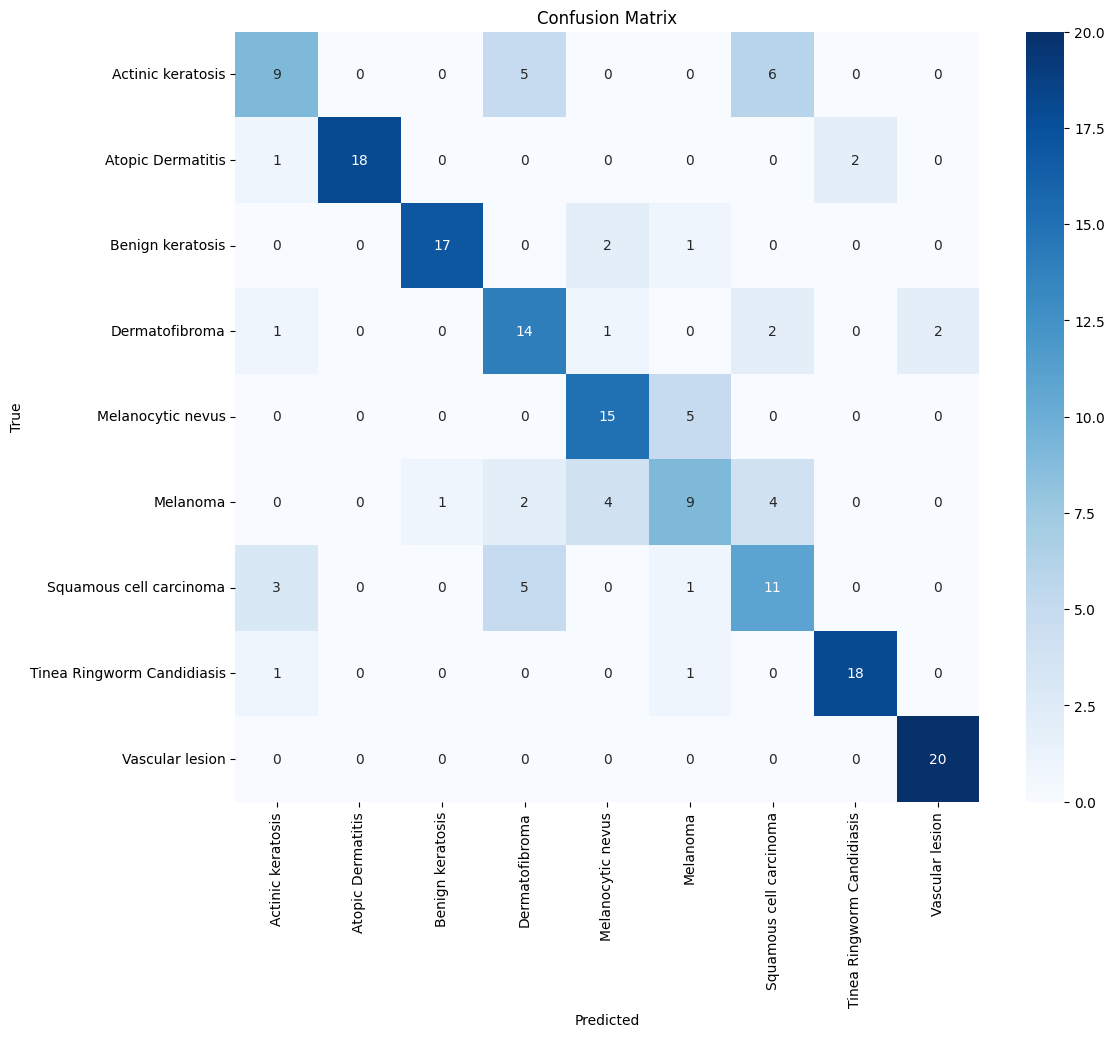


Classification Report:

                            precision    recall  f1-score   support

         Actinic keratosis       0.60      0.45      0.51        20
         Atopic Dermatitis       1.00      0.86      0.92        21
          Benign keratosis       0.94      0.85      0.89        20
            Dermatofibroma       0.54      0.70      0.61        20
         Melanocytic nevus       0.68      0.75      0.71        20
                  Melanoma       0.53      0.45      0.49        20
   Squamous cell carcinoma       0.48      0.55      0.51        20
Tinea Ringworm Candidiasis       0.90      0.90      0.90        20
           Vascular lesion       0.91      1.00      0.95        20

                  accuracy                           0.72       181
                 macro avg       0.73      0.72      0.72       181
              weighted avg       0.73      0.72      0.72       181



In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ================== 12. CONFUSION MATRIX + CLASSIFICATION REPORT ==================
print("\n[Evaluation] Generating predictions for confusion matrix & report...")
val_preds = model.predict(val_gen, verbose=1)
y_true = val_gen.classes  # True labels
y_pred = np.argmax(val_preds, axis=1)  # Predicted class indices

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:\n")
print(report)